In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import preprocessUtils as putils
import pandas as pd
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from mpl_toolkits.basemap import Basemap
from numpy import meshgrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, TwoSlopeNorm
from matplotlib.lines import Line2D  # For custom legend entries


/glade/work/klesinger/conda-envs/tf212gpu_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.system(f'mkdir -p test_bias')
os.chdir('test_bias')

In [3]:
os.getcwd()

'/glade/work/klesinger/FD_RZSM_deep_learning/test_bias'

In [4]:
region_name = 'CONUS'
global mask
mask = putils.return_proper_mask_for_bounding(region_name)


Latitude values for mask is [50.  49.5 49.  48.5 48.  47.5 47.  46.5 46.  45.5 45.  44.5 44.  43.5
 43.  42.5 42.  41.5 41.  40.5 40.  39.5 39.  38.5 38.  37.5 37.  36.5
 36.  35.5 35.  34.5 34.  33.5 33.  32.5 32.  31.5 31.  30.5 30.  29.5
 29.  28.5 28.  27.5 27.  26.5]

Longitude values for mask is [238.  238.5 239.  239.5 240.  240.5 241.  241.5 242.  242.5 243.  243.5
 244.  244.5 245.  245.5 246.  246.5 247.  247.5 248.  248.5 249.  249.5
 250.  250.5 251.  251.5 252.  252.5 253.  253.5 254.  254.5 255.  255.5
 256.  256.5 257.  257.5 258.  258.5 259.  259.5 260.  260.5 261.  261.5
 262.  262.5 263.  263.5 264.  264.5 265.  265.5 266.  266.5 267.  267.5
 268.  268.5 269.  269.5 270.  270.5 271.  271.5 272.  272.5 273.  273.5
 274.  274.5 275.  275.5 276.  276.5 277.  277.5 278.  278.5 279.  279.5
 280.  280.5 281.  281.5 282.  282.5 283.  283.5 284.  284.5 285.  285.5]


In [5]:
#Open OBS soil file CONUS
# obs = xr.open_mfdataset('/glade/work/klesinger/FD_RZSM_deep_learning/Data/GLEAM/RZSM_anomaly_reformat_SubX_format/CONUS/*')

#First convert all of the raw observations into the SubX format
obs = xr.open_dataset('/glade/work/klesinger/FD_RZSM_deep_learning/Data/GLEAM/RZSM_weighted_mean_0_100cm.nc4')
obs


<xarray.Dataset>
Dimensions:    (time: 8766, longitude: 108, latitude: 54)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2022-12-31
  * longitude  (longitude) float64 235.0 235.5 236.0 236.5 ... 287.5 288.0 288.5
  * latitude   (latitude) float64 50.0 49.5 49.0 48.5 ... 25.0 24.5 24.0 23.5
Data variables:
    SMsurf     (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.2.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    Dataset:      Global Land Evaporation Amsterdam Model
    Version:      3.8a
    Authors:      Hydro-Climate Extremes Lab (H-CEL)
    Institution:  Ghent University
    Contact:      info@gleam.eu
    Reference1:   Martens, B. et al. 2017: GLEAM v3: satellite-based land eva...
    Reference2:   Miralles, D.G. et al. 2011: Global land-surface evaporation...
    NCO:          netCDF Operators version 4.9.1 (Homepage = http://nco.sf.ne...
    history:      Tue Nov 21 17:00:56 2023: cdo -add -mulc,0.1 RZSM_0_10cm.nc...
    CDO:          Climate Data Operators version 2.2.2 (https://mpimet.mpg.de...

In [6]:
global init_date_list
import datetime as dt

init_date_list = putils.get_init_date_list(forecast_variable_path=f'/glade/work/klesinger/FD_RZSM_deep_learning/Data/GEFSv12_reforecast/soilw_bgrnd')
init_date_list_datetime = [pd.to_datetime(i) for i in init_date_list]

In [7]:
#template for overwriting
ref_dir = f'/glade/work/klesinger/FD_RZSM_deep_learning/Data/ECMWF/soilw_bgrnd_processed/CONUS' #Just use a single reference directory to serve as the template for file creation

global template
#Grab a single SubX to use as the template. Doesn't matter if it is the same variable or not or the same date

template = sorted(glob(f'{ref_dir}/*.n*'))[0]
template = xr.open_dataset(template)


def convert_OBS_to_SubX_format(_date: str) -> None:  
# for _date in init_date_list:
    # var='RZSM_weighted'
    # _date=init_date_list[0]

    
    '''We are going to create new leads that are different than reforecast. The reasoning for this is that we want the actual weekly lags (and 1 day lag) and this will
    assist with future predictions within the deep learning model'''

    if region_name == 'CONUS':
        #Currently the GLEAM and ERA observations are in a format with only positive values for the longitude.
        #The current reforecast has negative values for those West of 0 degrees
        
        new_X_coords = [i+360 if i < 0 else i for i in template.X.values]
        single_file = template.assign_coords({'X':new_X_coords})
        single_file = xr.zeros_like(single_file)
        open_date_SubX = putils.restrict_to_bounding_box(single_file,mask)
        
    elif region_name != 'CONUS':
        open_date_SubX = template
        open_date_SubX = xr.zeros_like(open_date_SubX)

    OBS_new = obs.sel(longitude = open_date_SubX.X.values, latitude=open_date_SubX.Y.values)


    save_dir = 'obs_raw_ECMWF_format'
    os.system(f'mkdir -p {save_dir}')
    obs_file_name = f'soilw_bgrnd_reformat_ECMWF_{_date}.nc4'
    save_file = f'{save_dir}/{obs_file_name}'

    if os.path.exists(save_file):
        # print(f'Completed date {_date}')
        pass
    else:
        out_file = open_date_SubX.copy(deep=True)

        '''We are going to create a new lead day that represents the previous day before the forecast was initialized
        #New shape will be (1x11x48xlatxlon)
        This will include the day lag 1, and weekly lags 1-12'''

        print(f'Working on initialized day {_date} to find values integrating with SubX models, leads, & coordinates and saving data into {save_dir}.')
        
        for idx,i_lead in enumerate(out_file.L.values):
            # break

            date_val = pd.to_datetime(pd.to_datetime(_date) + dt.timedelta(days=int(i_lead)+0)) #Adding +1 may be suitable for other forecasts which predict the next day. But GEFSv12 predicts lead 0 as 12 UTC on the same date it is initialized
            #But be careful if you adapt this code to a new script. We are looking backwards in time from the first date.
                
            date_val = f'{date_val.year}-{date_val.month:02}-{date_val.day:02}'

            out_file[putils.xarray_varname(out_file)][0,:, idx, :, :] = \
                OBS_new[putils.xarray_varname(obs)].sel(time = date_val).values

        var_OUT = xr.Dataset(
            data_vars = dict(
                RZSM = (['S','M','L','Y','X'],    out_file[putils.xarray_varname(out_file)].values),
            ),
            coords = dict(
                S = np.atleast_1d(_date),
                X = open_date_SubX.X.values,
                Y = open_date_SubX.Y.values,
                L = out_file.L.values,
                M = open_date_SubX.M.values,

            ),
            attrs = dict(
                Description = f' GLEAM values on the exact same date and grid \
                cell as ECMWF reforecast data. Raw data.'),
        )                    

        var_OUT = var_OUT.astype(np.float32) #all the files need to be in float32 for the deep learning algorithm to work best
        
        #Save as a netcdf for later processing
        var_OUT.to_netcdf(path = save_file, mode ='w')

    return(0)


for _date  in init_date_list:
    convert_OBS_to_SubX_format(_date)



# Now we need to open both files and get the MAE by lead time

In [8]:
obs_raw = xr.open_mfdataset('/glade/work/klesinger/FD_RZSM_deep_learning/test_bias/obs_raw_ECMWF_format/*')


In [9]:
fcst_dir = '/glade/work/klesinger/FD_RZSM_deep_learning/Data/ECMWF/soilw_bgrnd_processed/CONUS'
var_name = 'soilw_bgrnd'
ref_raw = putils.return_ECMWF_reforecast_files_by_concatenation(dir_path = fcst_dir, name_of_var = var_name, region_name = region_name,init_date_list = init_date_list)



Latitude values for mask is [50.  49.5 49.  48.5 48.  47.5 47.  46.5 46.  45.5 45.  44.5 44.  43.5
 43.  42.5 42.  41.5 41.  40.5 40.  39.5 39.  38.5 38.  37.5 37.  36.5
 36.  35.5 35.  34.5 34.  33.5 33.  32.5 32.  31.5 31.  30.5 30.  29.5
 29.  28.5 28.  27.5 27.  26.5]

Longitude values for mask is [238.  238.5 239.  239.5 240.  240.5 241.  241.5 242.  242.5 243.  243.5
 244.  244.5 245.  245.5 246.  246.5 247.  247.5 248.  248.5 249.  249.5
 250.  250.5 251.  251.5 252.  252.5 253.  253.5 254.  254.5 255.  255.5
 256.  256.5 257.  257.5 258.  258.5 259.  259.5 260.  260.5 261.  261.5
 262.  262.5 263.  263.5 264.  264.5 265.  265.5 266.  266.5 267.  267.5
 268.  268.5 269.  269.5 270.  270.5 271.  271.5 272.  272.5 273.  273.5
 274.  274.5 275.  275.5 276.  276.5 277.  277.5 278.  278.5 279.  279.5
 280.  280.5 281.  281.5 282.  282.5 283.  283.5 284.  284.5 285.  285.5]

Loading files for variable soilw_bgrnd
We are changing the coordinates of CONUS to match similar format as GLE

NameError: name 't' is not defined

In [19]:
dd = [pd.to_datetime(i) for i in obs_raw.S.values]

In [20]:
obs_raw['S'] = dd

In [ ]:
mae = np.abs(obs_raw - ref_raw)
mae = mae.mean(dim='M').mean(dim='S').load()  #Data to plot
max_,min_ = np.nanmax(mae.RZSM.values), np.nanmin(mae.RZSM.values)

In [46]:
bias = obs_raw - ref_raw
bias = bias.mean(dim='M').mean(dim='S').load()  #Data to plot
max_,min_ = np.nanmax(bias.RZSM.values), np.nanmin(bias.RZSM.values)

In [ ]:
'''MAE'''
cmap = 'autumn'

fig, axs = plt.subplots(
    nrows = 9, ncols= 5, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 15), dpi=300)

axs = axs.flatten()

lon = mae.X.values
lat = mae.Y.values

axs_start = 0
for lead in mae.L.values:
    # break
    data = mae.RZSM.sel(L=lead).values
    mean = np.nanmean(data)
    
    v = np.linspace(min_, max_, 100, endpoint=True)

    map = Basemap(projection='cyl', llcrnrlat=lat[-1] - 1.5, urcrnrlat=lat[0],
                  llcrnrlon=(lon[0] - 360 - 6), urcrnrlon=(lon[-1] - 360 + 20), resolution='l')
    
    x, y = map(*np.meshgrid(lon, lat))
    # Adjust the text coordinates based on the actual data coordinates

    im = axs[axs_start].contourf(x, y, data, levels=v, extend='both',
                          transform=ccrs.PlateCarree(), cmap=cmap)
    
    axs[axs_start].coastlines()
    axs[axs_start].set_aspect('equal')  # this makes the plots better
    axs[axs_start].set_title(f'Lead {lead}: Error ={str(mean)[0:8]}',fontsize=8)
    axs_start+=1

cbar_ax = fig.add_axes([0.05, 0.03, .9, .04])

# Draw the colorbar
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
plt.suptitle(f'Bias (OBS - FCST)', fontsize=20)
plt.tight_layout()

plt.savefig(f'average_bias_over_all_inits_GLEAM_ECMWF.png')


/glade/derecho/scratch/klesinger/tmp/ipykernel_63355/1820114318.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


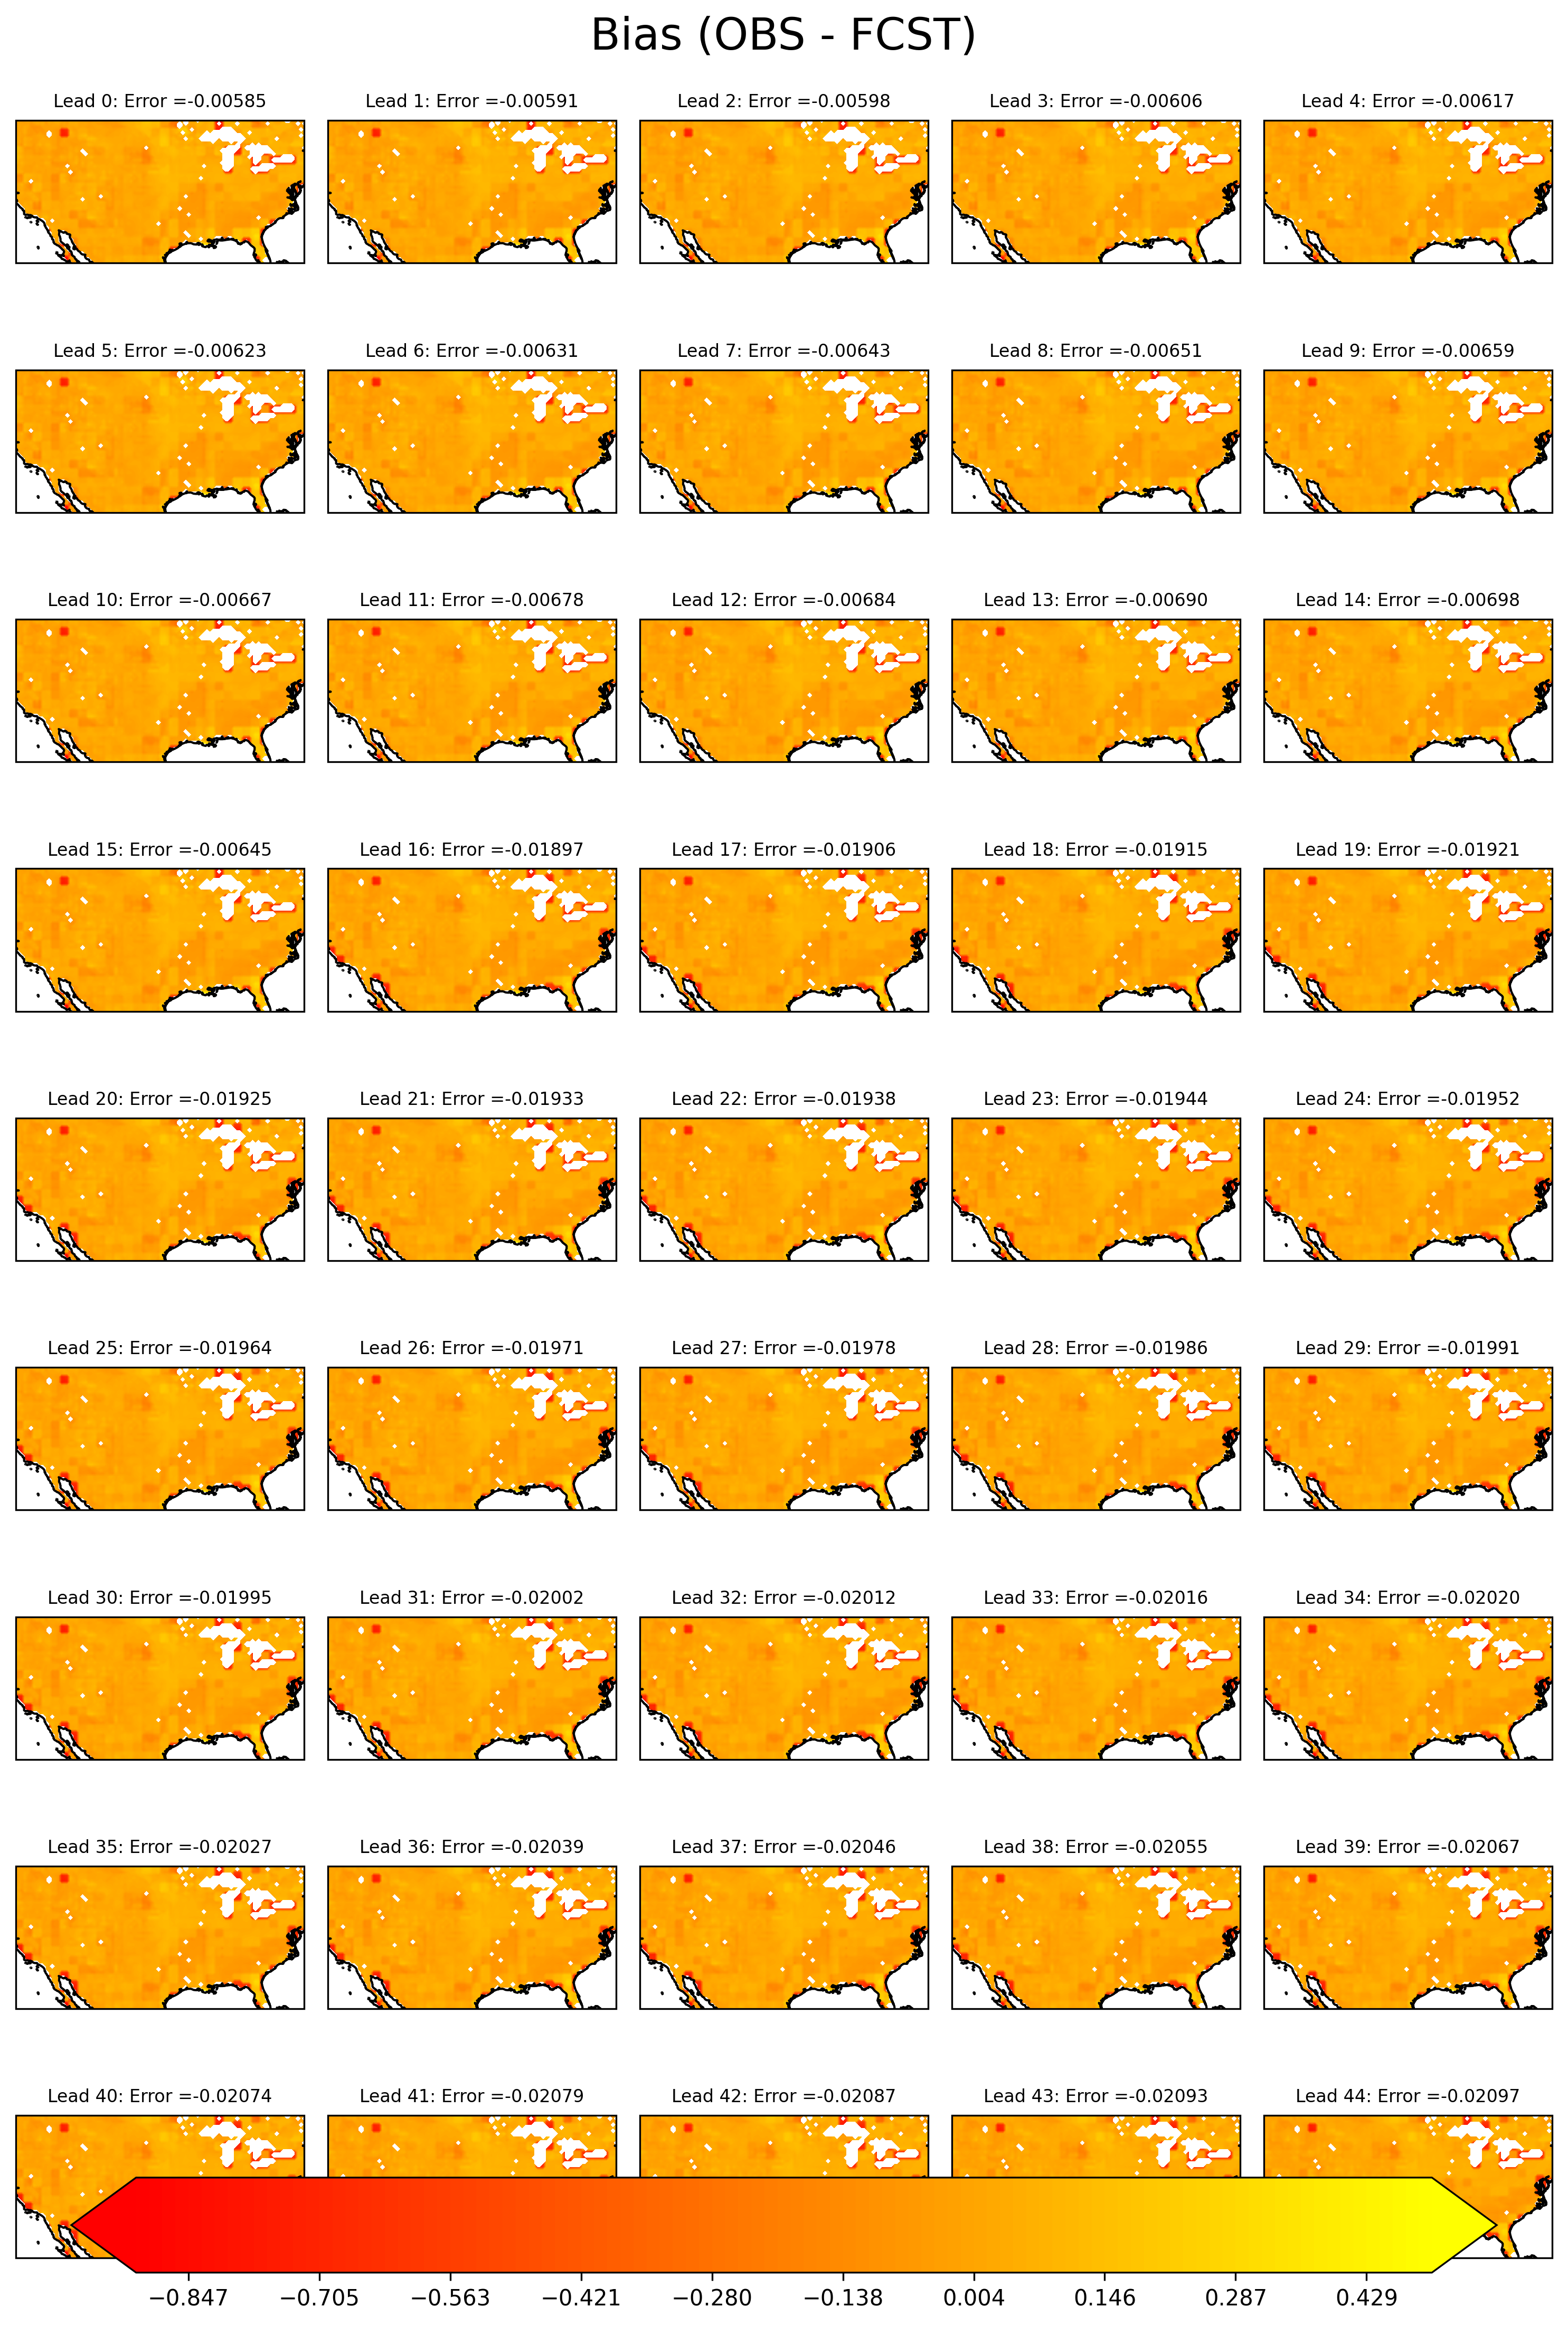

In [61]:

cmap = 'autumn'

fig, axs = plt.subplots(
    nrows = 9, ncols= 5, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 15), dpi=300)

axs = axs.flatten()

lon = mae.X.values
lat = mae.Y.values

axs_start = 0
for lead in mae.L.values:
    # break
    data = bias.RZSM.sel(L=lead).values
    mean = np.nanmean(data)
    
    v = np.linspace(min_, max_, 100, endpoint=True)

    map = Basemap(projection='cyl', llcrnrlat=lat[-1] - 1.5, urcrnrlat=lat[0],
                  llcrnrlon=(lon[0] - 360 - 6), urcrnrlon=(lon[-1] - 360 + 20), resolution='l')
    
    x, y = map(*np.meshgrid(lon, lat))
    # Adjust the text coordinates based on the actual data coordinates

    im = axs[axs_start].contourf(x, y, data, levels=v, extend='both',
                          transform=ccrs.PlateCarree(), cmap=cmap)
    
    axs[axs_start].coastlines()
    axs[axs_start].set_aspect('equal')  # this makes the plots better
    axs[axs_start].set_title(f'Lead {lead}: Error ={str(mean)[0:8]}',fontsize=8)
    axs_start+=1

cbar_ax = fig.add_axes([0.05, 0.03, .9, .04])

# Draw the colorbar
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
plt.suptitle(f'Bias (OBS - FCST)', fontsize=20)
plt.tight_layout()

plt.savefig(f'average_bias_over_all_inits_GLEAM_ECMWF.png')


/glade/derecho/scratch/klesinger/tmp/ipykernel_63355/747016283.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


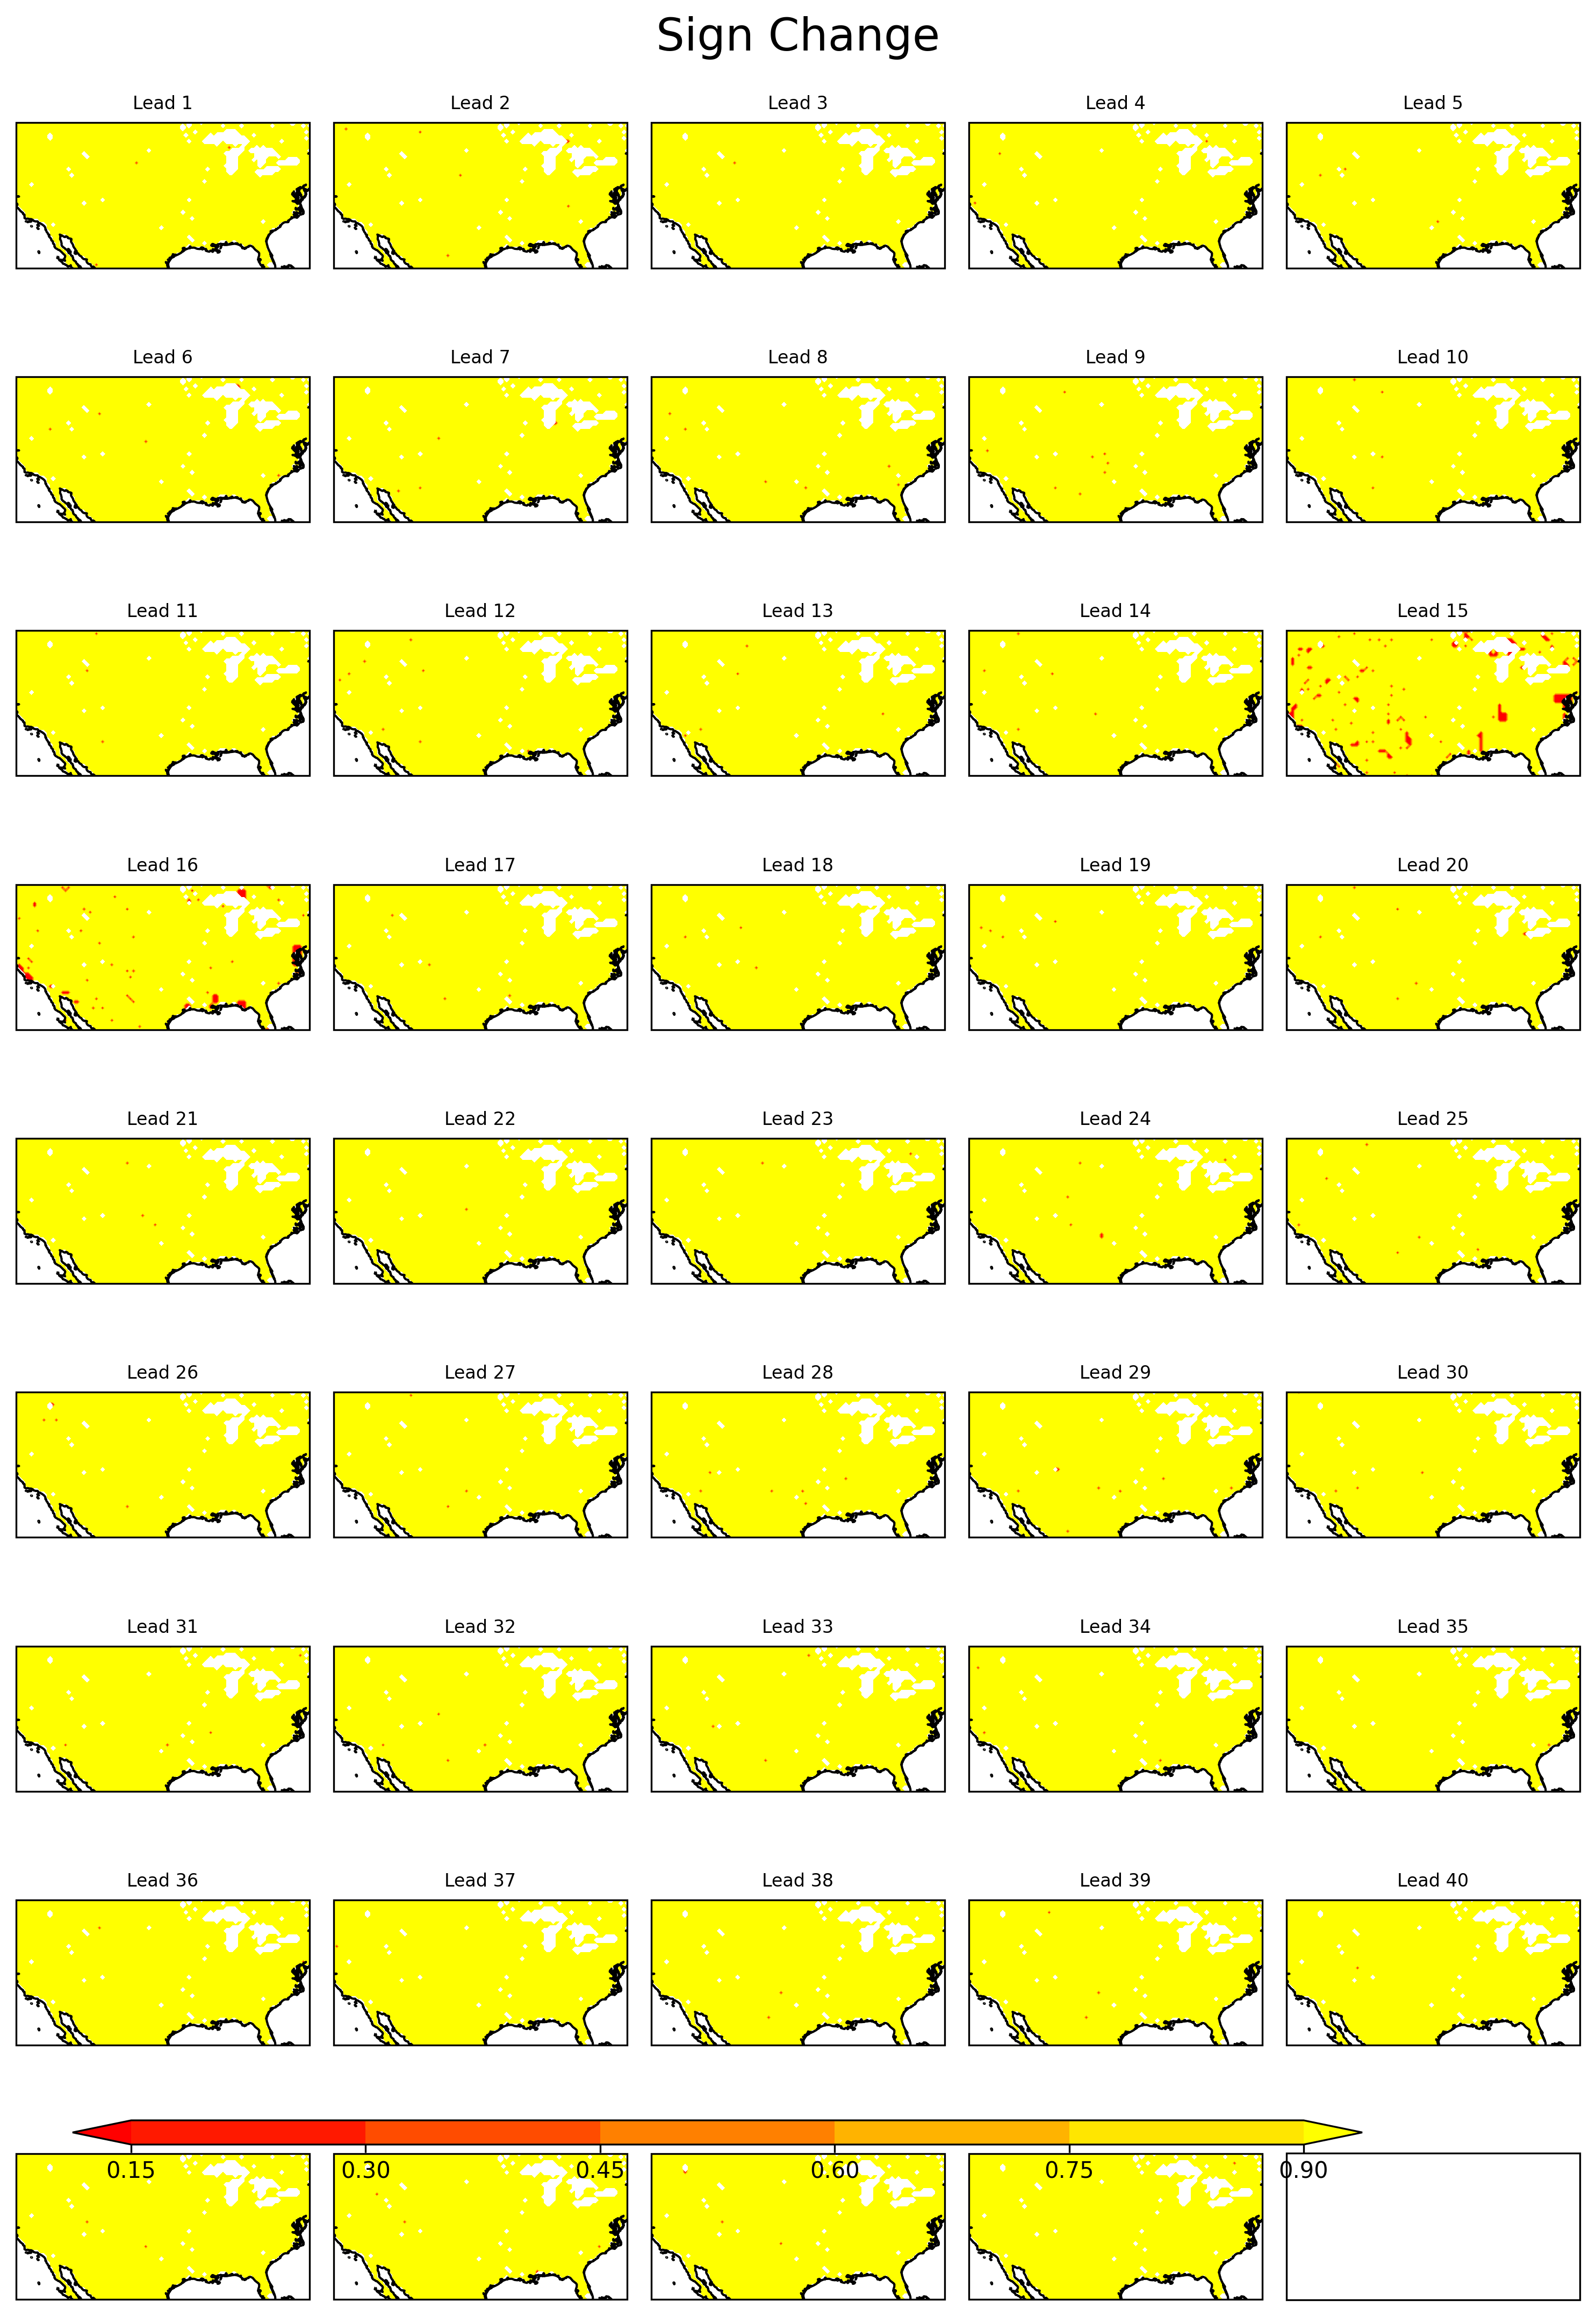

In [85]:
#Now make a plot where if the current day is less than the previous day then we place a value of a 1; else 0


'''Seeing if there is a sign change'''
cmap = 'autumn'

fig, axs = plt.subplots(
    nrows = 9, ncols= 5, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 15), dpi=300)

axs = axs.flatten()

lon = mae.X.values
lat = mae.Y.values

axs_start = 0
for lead in mae.L.values:
    if lead ==0:
        pass
    else:
        # break
        data = bias.RZSM.sel(L=lead).values
        prev = bias.RZSM.sel(L=lead-1).values

        # Check if signs are the same
        same_sign = np.logical_and(data > 0, prev > 0) | np.logical_and(data < 0, prev < 0)
        same_sign = np.where(np.isnan(data),np.nan,same_sign)

        map = Basemap(projection='cyl', llcrnrlat=lat[-1] - 1.5, urcrnrlat=lat[0],
                      llcrnrlon=(lon[0] - 360 - 6), urcrnrlon=(lon[-1] - 360 + 20), resolution='l')
        
        x, y = map(*np.meshgrid(lon, lat))
        # Adjust the text coordinates based on the actual data coordinates
    
        im = axs[axs_start].contourf(x, y, same_sign, extend='both',
                              transform=ccrs.PlateCarree(), cmap=cmap)
        
        axs[axs_start].coastlines()
        axs[axs_start].set_aspect('equal')  # this makes the plots better
        axs[axs_start].set_title(f'Lead {lead}',fontsize=8)
        axs_start+=1

cbar_ax = fig.add_axes([0.05, 0.1, .8, .01])

# Draw the colorbar
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
plt.suptitle(f'Sign Change', fontsize=20)
plt.tight_layout()

plt.savefig(f'sign_change_GLEAM_ECMWF.png')
